## Plotting Locations on Africa

### Load Africa Shapefile from .pkl

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from shapely.geometry import Point, Polygon

import pandas as pd
import numpy as np
import pickle as pkl
import os

# Root path where all data is stored
dhs_surveys_path = "/atlas/group/poverty_data/surveys/dhs/"

africa_shape_file = "/atlas/group/poverty_data/shape_files/africa/africa.pkl"
with open(africa_shape_file, 'rb') as f:
    # in Python 3
    africa_polygon = pkl.load(f, encoding='bytes')
    
    # in Python 2.7
    # pkl.load(f)

print(africa_polygon.bounds)
print(type(africa_polygon))

(-17.532779693603516, -34.82200241088867, 51.41131591796875, 37.34041213989258)
<class 'shapely.geometry.polygon.Polygon'>


Get useful values, define some constants. Define helper functions to plot Africa outline and determine whether or not a lat/lon point is within a given polygon.

In [9]:
africa_bounds_coords = list(africa_polygon.exterior.coords)
africa_bounds_x, africa_bounds_y = zip(*africa_bounds_coords) # unzip

countries = ['malawi_2010', 'nigeria_2013', 'rwanda_2010', 'tanzania_2010', 'uganda_2011']
degrees_per_px = 0.000134747292618
image_size = 224*degrees_per_px

def plot_africa_border(ax):
    ax.scatter(africa_bounds_x, africa_bounds_y, color='black', marker='.', s=1)
    ax.set_xlim(-18, 53)
    ax.set_ylim(-36, 38)

def is_lat_lon_in_polygon(lat, lon, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

Plot African border

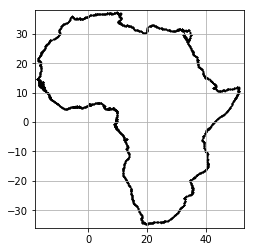

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
ax.grid()
plot_africa_border(ax)

As a test, overlay a grid on top of Africa. The grid CSV was created using the following command:

```
python all_africa_csv.py -i /atlas/group/africa_composites/landsat7/2011/2011_africa_pansharpened.tif -ih 224 -iw 224 -o all_africa_l7_2011_ih224_iw224_sh0_sw0.csv
```

(5523, 3)


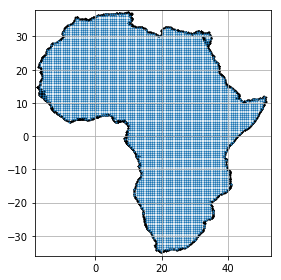

In [17]:
import pandas as pd
locs = pd.read_csv('/atlas/u/chrisyeh/LandsatPoverty/create_csvs/output.csv').values
print(locs.shape)

cluster_locs = []
for loc in locs:
    if is_lat_lon_in_polygon(loc[0], loc[1], africa_polygon):
        cluster_locs.append(loc)
locs = np.array(cluster_locs)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
ax.grid()
plot_africa_border(ax)

# Scatter plot
ax.scatter(locs[:,1], locs[:,0], marker="o", s=1)

fig.tight_layout()

Num locations for malawi_2010: 827
Num locations for nigeria_2013: 889
Num locations for rwanda_2010: 492
Num locations for tanzania_2010: 458
Num locations for uganda_2011: 400


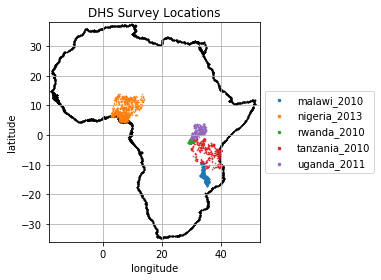

In [44]:
# plot DHS survey locations on Africa polygon
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(1,1,1)

ax.set_aspect('equal')
ax.grid()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('DHS Survey Locations')

# plot Africa border
plot_africa_border(ax)

for country in countries:
    # Load cluster location data for the country
    # Rows are locations/clusters. Columns are lat and lon
    cluster_locs_filename = os.path.join(dhs_surveys_path, country, 'locs.npy')
    cluster_locs = np.load(cluster_locs_filename)
    print("Num locations for {0}: {1}".format(country, len(cluster_locs)))

    # Scatter plot
    ax.scatter(cluster_locs[:,1], cluster_locs[:,0], marker=".", s=1, label=country)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=5)

fig.tight_layout()
fig.savefig('dhs_survey_locations_all.png', transparent=True, bbox_inches='tight', pad_inches=0)

NL Class 0, validation: 2805 entries.
NL Class 0, train: 59896 entries.
NL Class 0, test: 1330 entries.
NL Class 0: 64031 total entries.
NL Class 1, validation: 883 entries.
NL Class 1, train: 18486 entries.
NL Class 1, test: 681 entries.
NL Class 1: 20050 total entries.
NL Class 2, validation: 788 entries.
NL Class 2, train: 13140 entries.
NL Class 2, test: 711 entries.
NL Class 2: 14639 total entries.


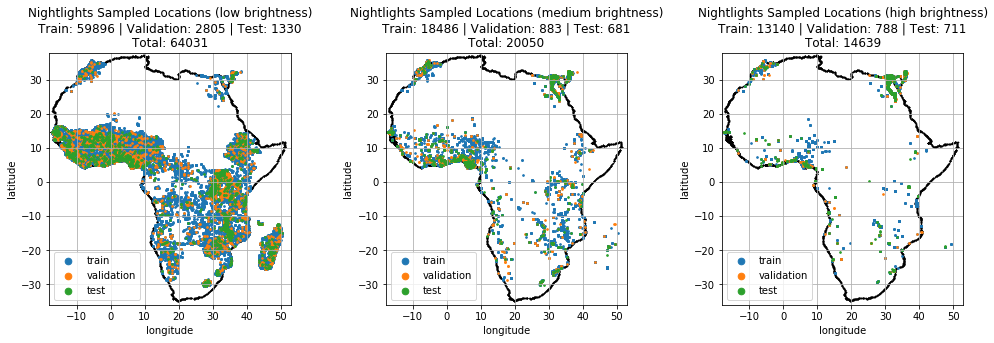

In [51]:
nightlights_csvs_dir = '/atlas/u/anthony/dhs_anthony/hyperspecral_Resnet_project_data/michael_locations_projection_fix'
datasets = {
    'train': [
        os.path.join(nightlights_csvs_dir, 'training_lat_lon_nlval_nlclass_assets_michael_assets_only.csv'),
        os.path.join(nightlights_csvs_dir, 'training_lat_lon_nlval_nlclass_assets_michael_no_assets.csv')
    ],
    'validation': [
        os.path.join(nightlights_csvs_dir, 'validation_lat_lon_nlval_nlclass_assets_michael.csv')
    ],
    'test': [
        os.path.join(nightlights_csvs_dir, 'test_lat_lon_nlval_nlclass_assets_michael.csv')
    ]
}
num_datasets = len(datasets)

nl_classes = [0, 1, 2]
nl_class_names = ['low', 'medium', 'high']
nl_class_totals = {}
num_nl_classes = len(nl_classes)

# dataset_to_class_to_locs =
# {  dataset_name: {
#      { nl_class : np.array of size [N, 2], each row is (lat, lon)
#      }
# }
dataset_to_class_to_locs = {}

for dataset_name, paths in datasets.items():
    # class_to_locs is a dict of {nl_class : locs}
        # - nl_class: int
        # - locs: [N, 2] ndarray, each row is (lat, lon)
    class_to_locs = {}
    for nl_class in nl_classes:
        class_to_locs[nl_class] = np.zeros([0, 2])
    
    for path in paths:
        data = pd.read_csv(path)
        
        for nl_class in nl_classes:
            filtered_data = data.loc[data['nl_class'] == nl_class]
            locs = filtered_data[['lat', 'lon']]
            class_to_locs[nl_class] = np.concatenate([class_to_locs[nl_class], locs.values], axis=0)

    dataset_to_class_to_locs[dataset_name] = class_to_locs


for i in range(num_nl_classes):
    nl_class = nl_classes[i]
    nl_class_totals[i] = 0
    
    for dataset_name in datasets:
        count = len(dataset_to_class_to_locs[dataset_name][nl_class])
        nl_class_totals[nl_class] += count
        print("NL Class {0}, {1}: {2} entries.".format(nl_class, dataset_name, count))
    
    print("NL Class {0}: {1} total entries.".format(nl_class, nl_class_totals[nl_class]))


# plot sampled nightlights locations on Africa polygon
fig = plt.figure(figsize=[14, 8])
dataset_plot_order = ['train', 'validation', 'test']

for i in range(num_nl_classes):
    nl_class = nl_classes[i]
    nl_class_name = nl_class_names[i]
    
    ax = fig.add_subplot(1, num_nl_classes, i+1)

    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    
    title_lines = [
        'Nightlights Sampled Locations (%s brightness)' % nl_class_name,
        'Train: %d | Validation: %d | Test: %d' % (
            len(dataset_to_class_to_locs['train'][nl_class]),
            len(dataset_to_class_to_locs['validation'][nl_class]),
            len(dataset_to_class_to_locs['test'][nl_class]),
        ),
        'Total: %d' % nl_class_totals[i]
    ]
    ax.set_title('\n'.join(title_lines))

    # plot Africa border
    plot_africa_border(ax)
    
    # plot all three datasets
    for dataset_name in dataset_plot_order:
        lats = dataset_to_class_to_locs[dataset_name][nl_class][:, 0]
        lons = dataset_to_class_to_locs[dataset_name][nl_class][:, 1]
        
        ax.scatter(lons, lats, marker='.', s=11, label=dataset_name)
    
    ax.legend(loc='best', markerscale=4)

fig.tight_layout()
fig.savefig('nightlights_sampling_per_class_with_counts.png', transparent=True, bbox_inches='tight', pad_inches=0)

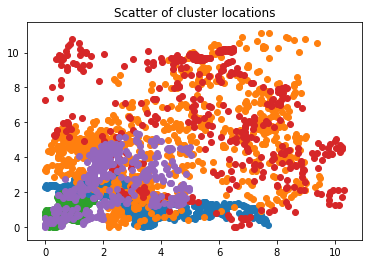

In [91]:
# PLOT 1: Scatter plot of clusters
for i in range(len(country)):
    # Load cluster location data for the country 
    cluster_locs_data = np.load(dhs_surveys_path+country[i]+"/locs.npy")
    # Rows are locations/clusters. Columns are lat and lon
    # Subtract minimum from both columns and plot
    cluster_locs_data -= np.min(cluster_locs_data, axis=0)
    # Scatter plot
    plt.scatter(cluster_locs_data[:,0], cluster_locs_data[:,1])
    plt.title("Scatter of cluster locations")
    # Save the figure
#     plt.savefig("visualize_surveys_results/scatter_lat_lon_"+country[i][:-6]+".png")
    # Clear figure
#     plt.clf()

In [ ]:
# # PLOT 2: Visualize images on scatter plot
# for i in range(len(country)):
#     # Load cluster location data for the country 
#     cluster_locs_data = np.load(root_pathname+country[i]+"cluster_locs.npy")
#     # Rows are locations/clusters. Columns are lat and lon
#     # Subtract minimum from both columns and plot
#     cluster_locs_data -= np.min(cluster_locs_data, axis=0)
#     cluster_locs_data -= 112*pixel_size*np.ones_like(cluster_locs_data)
#     # Scatter plot
#     plt.scatter(cluster_locs_data[:,0], cluster_locs_data[:,1],marker="o", s=1)
#     # Plot rectangles
#     currentAxis = plt.gca()
#     for j in range(cluster_locs_data.shape[0]):
#         currentAxis.add_patch(Rectangle((cluster_locs_data[j,0], cluster_locs_data[j,1]), image_size, image_size, facecolor="grey"))
#     plt.title("Scatter with images at cluster locations")
#     # Save the figure
#     plt.savefig("visualize_surveys_results/scatter_with_images_lat_lon_"+country[i][:-6]+".png")
#     # Clear figure
#     plt.clf()

# # PLOT 3: Visualize histogram of assets
# for i in range(len(country)):
#     # Load cluster location data for the country 
#     cluster_locs_data = np.load(root_pathname+country[i]+"cluster_locs.npy")
#     # Load cluster asset data for the country
#     cluster_assets_data = np.load(root_pathname+country[i]+"cluster_assets.npy")
#     # Scale assets to between 0 and 1
#     asset_max = np.max(cluster_assets_data)
#     asset_min = np.min(cluster_assets_data)
#     cluster_assets_data = (cluster_assets_data - asset_min)/float(asset_max - asset_min)
#     # Histogram
#     n, bins, patches = plt.hist(cluster_assets_data, 50, normed=1, facecolor='green', alpha=0.75)
#     # Title
#     plt.title("Histogram of 0-1 Scaled Cluster Assets")
#     # Save the figure
#     plt.savefig("visualize_surveys_results/hist_scaled_assets_"+country[i][:-6]+".png")
#     # Clear figure
#     plt.clf()